Done by: Tanjuma Haque
Homework: Advanced Dimensionality Reduction (DL 3.11.)

In [48]:
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


## TASK 1

In [49]:

# loading the .arff file
data, meta = arff.loadarff('dataset.arff')

# converting to pandas DataFrame
df = pd.DataFrame(data)

df = df.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
print(df.head())

   season  year  month  hour holiday  weekday workingday weather  temp  \
0  spring   0.0    1.0   0.0   False      6.0      False   clear  9.84   
1  spring   0.0    1.0   1.0   False      6.0      False   clear  9.02   
2  spring   0.0    1.0   2.0   False      6.0      False   clear  9.02   
3  spring   0.0    1.0   3.0   False      6.0      False   clear  9.84   
4  spring   0.0    1.0   4.0   False      6.0      False   clear  9.84   

   feel_temp  humidity  windspeed  casual  registered  count  
0     14.395      0.81        0.0     3.0        13.0   16.0  
1     13.635      0.80        0.0     8.0        32.0   40.0  
2     13.635      0.80        0.0     5.0        27.0   32.0  
3     14.395      0.75        0.0     3.0        10.0   13.0  
4     14.395      0.75        0.0     0.0         1.0    1.0  


In [50]:
# separating target variable
target_col = 'count'
y = df[target_col]

# dropping target
X = df.drop(columns=[target_col])

# manually define which are truly categorical vs continuous numeric
categorical_cols = ['season', 'holiday', 'workingday', 'weather']
numeric_cols = ['year', 'month', 'hour', 'weekday', 'temp', 'feel_temp', 'humidity', 'windspeed', 'casual', 'registered']

# one-hot encode categorical features only
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# scale numeric features only (keep dummy columns as they are 0/1)
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

# now your scaled dataset is ready for PCA
X_scaled = X_encoded.copy()

print("Final feature matrix shape:", X_scaled.shape)
print("Target variable shape:", y.shape)

Final feature matrix shape: (17379, 18)
Target variable shape: (17379,)


## PCA 

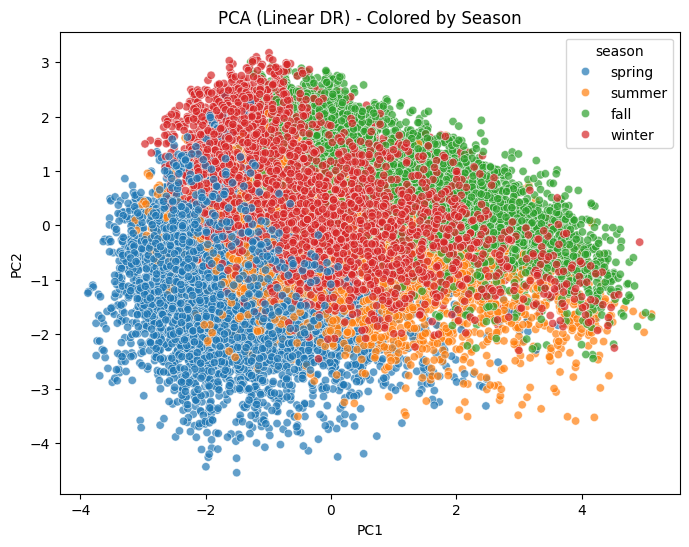

Explained variance ratio: [0.2626458  0.15711477]


In [51]:
# performing PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# creating a dataframe for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['humidity'] = df['humidity'] 
pca_df['season'] = df['season']

# plotting
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='season', palette='tab10', alpha=0.7)
plt.title('PCA (Linear DR) - Colored by Season')
plt.show()

# checking explained variance
print('Explained variance ratio:', pca.explained_variance_ratio_)

The plot above shows the PCA projection of the dataset onto the first two PCs, colored by season.
Each point (observation) is placed according to how its features combine along the two directions that capture the highest variance in the data.

The color gradient shows gradual transitions rather than fully separate clusters, indicating that seasonal effects contribute significantly to the overall variance, but with overlapping environmental conditions across seasons.
A general change can be seen along PC1, where the data shifts from predominantly spring observations on the left toward fall and winter on the right.
This implies that temperature-related variables play a vital role in driving the first principal component.
The PCA loadings also showcase this that temp and feel_temp have the largest influence on PC1, reinforcing the interpretation that temperature is the dominant factor shaping seasonal variation in the dataset.

In [52]:
loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC1', 'PC2'], 
                        index=X_encoded.columns)
print(loadings.sort_values(by='PC1', ascending=False).head(10))

                    PC1       PC2
temp           0.492016  0.288409
feel_temp      0.488667  0.307164
casual         0.444702 -0.152628
registered     0.401863 -0.184383
hour           0.252047 -0.320161
month          0.134703  0.408300
year           0.114593 -0.118456
windspeed      0.053761 -0.425070
season_summer  0.031033 -0.022154
weekday        0.013736 -0.040633


In [53]:
print(loadings.sort_values(by='PC2', ascending=False).head(10))

                         PC1       PC2
humidity           -0.207354  0.510215
month               0.134703  0.408300
feel_temp           0.488667  0.307164
temp                0.492016  0.288409
season_winter      -0.021002  0.078249
weather_misty      -0.027741  0.036740
workingday_True    -0.004833  0.020189
weather_rain       -0.021419  0.020114
weather_heavy_rain -0.000158 -0.000101
holiday_True       -0.001793 -0.001364


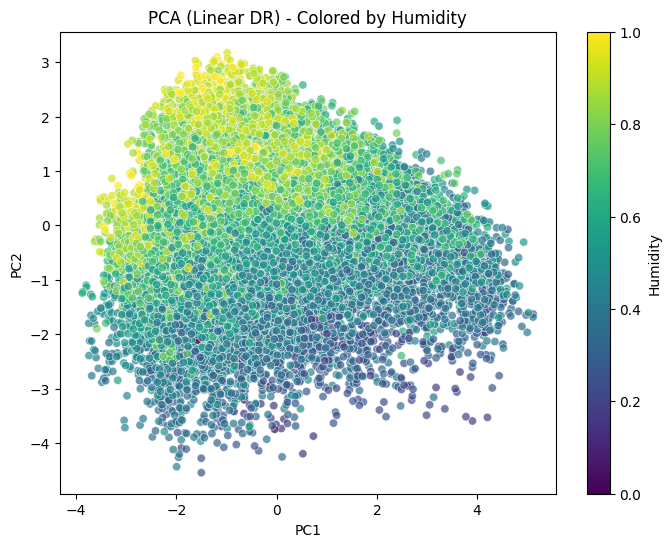

In [54]:
plt.figure(figsize=(8,6))

# creating the scatterplot for continuous variable
ax = sns.scatterplot(
    data=pca_df, 
    x='PC1', 
    y='PC2', 
    hue='humidity', 
    palette='viridis', 
    alpha=0.7, 
    legend=False
)

plt.title('PCA (Linear DR) - Colored by Humidity')

norm = mpl.colors.Normalize(vmin=pca_df['humidity'].min(), vmax=pca_df['humidity'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax, label='Humidity')

plt.show()

In this plot, each point is colored according to its humidity value, represented by the continuous color scale on the right.

A clear gradient can be observed along the vertical axis (PC2), where higher humidity values (yellow) appear toward the upper region and lower humidity values (purple) toward the bottom.
This indicates that PC2 captures variation primarily related to humidity, while PC1 continues to represent the broader temperature- and season-related variance observed in the previous plot.

Together, these two components show that PCA effectively summarizes the dataset’s dominant climatic factors, temperature and humidity, which jointly influence bike rental behavior.
The smooth gradient confirms that humidity contributes to secondary variation within the dataset, complementing the temperature-driven trend captured by PC1.

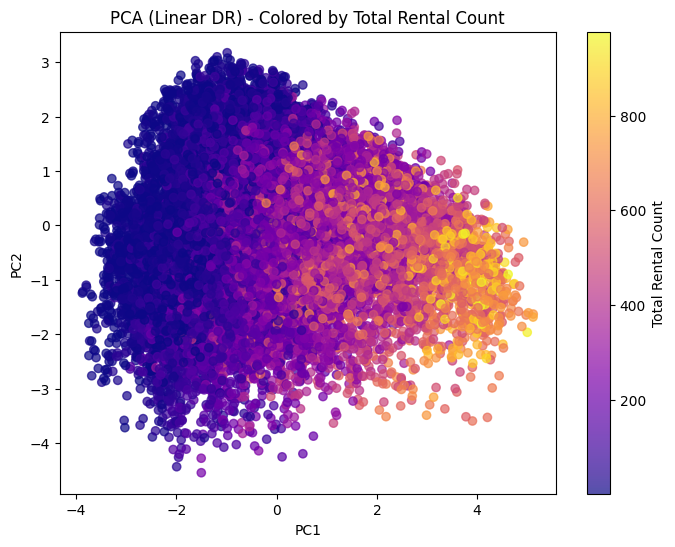

In [55]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                      c=df['count'], cmap='plasma', alpha=0.7)
plt.title('PCA (Linear DR) - Colored by Total Rental Count')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Total Rental Count')
plt.show()

In this plot above, each data point represents an observation placed according to its combined feature values, with color indicating the total number of rental bikes (count).
The gradient from dark purple to bright yellow shows increasing rental counts across the PCA space.

A clear pattern emerges along PC1, where higher rental counts correspond to higher PC1 values.
This aligns with the PCA loadings, where temperature-related variables such as temp and feel_temp contribute most strongly to PC1.
This pattern suggests that bike rental demand increases under warmer and more favorable seasonal conditions.

Overall, this visualization demonstrates that PCA not only captures the dominant climatic variance in the dataset but also aligns closely with the target variable, confirming that the same environmental components influencing variance are those driving rental activity.

# TSNE

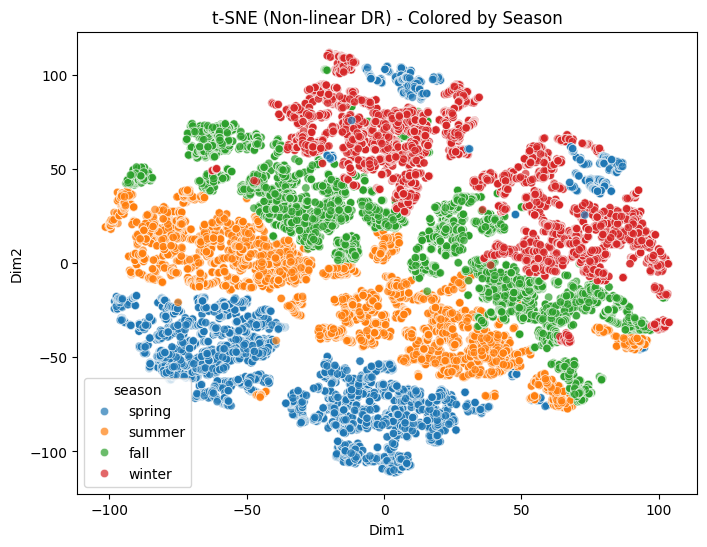

In [56]:

# applying t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['humidity'] = df['humidity']
tsne_df['season'] = df['season']

plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='season', palette='tab10', alpha=0.7)
plt.title('t-SNE (Non-linear DR) - Colored by Season')
plt.show()

Unlike PCA, which identifies linear directions of maximum variance, t-SNE is a non-linear dimensionality reduction method that focuses on preserving local neighborhood relationships.
Essentially, points that appear close together in this plot were also close in the original 18-dimensional feature space.

Distinct and compact clusters are visible for each season, with minimal overlap as can been seen in the plott above.
This indicates that t-SNE captures the underlying non-linear structure of the dataset more effectively than PCA, revealing stronger seasonal separation.
Within each seasonal cluster, small sub-clusters can also be observed, suggesting finer variations within each season, likely differences in time of day or weather conditions.

Overall, this visualization demonstrates that t-SNE provides a clearer and more localized separation of the data compared to PCA, especially when relationships among features are non-linear.

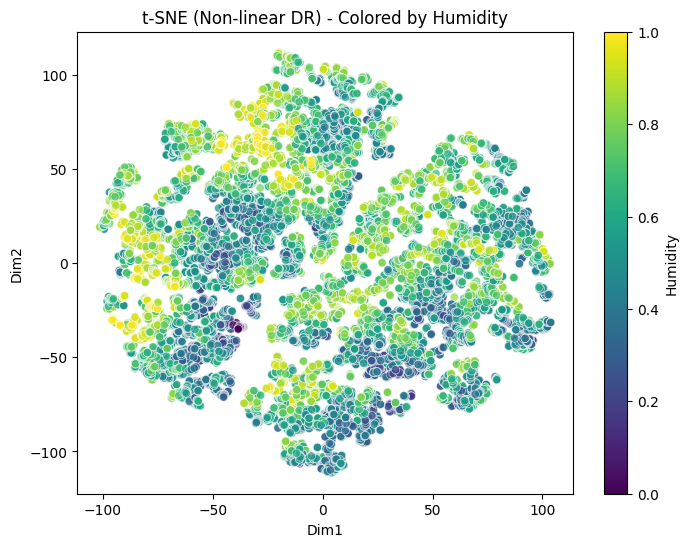

In [57]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(
    data=tsne_df, 
    x='Dim1', 
    y='Dim2', 
    hue='humidity', 
    palette='viridis', 
    alpha=0.7, 
    legend=False
)

plt.title('t-SNE (Non-linear DR) - Colored by Humidity')

norm = mpl.colors.Normalize(vmin=tsne_df['humidity'].min(), vmax=tsne_df['humidity'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Humidity')

plt.show()

This visualization above reveals multiple compact clusters that differ in their humidity levels.
Brighter yellow regions correspond to higher humidity, while darker purple areas represent lower humidity.
Although the t-SNE axes (Dim1 and Dim2) have no direct physical interpretation, the clear grouping pattern indicates that humidity strongly influences local structure in the data.
Observations with similar humidity values tend to cluster together, emphasizing the presence of non-linear relationships among environmental variables.

Overall, this t-SNE visualization highlights finer, localized variations in humidity that are less apparent in PCA, demonstrating how non-linear dimensionality reduction provides a more detailed view of environmental effects in the dataset.

In [58]:
# Create a model-ready version of the dataset (more accurate for Random Forest)
categorical_model = ['season', 'holiday', 'workingday', 'weather', 'month', 'weekday', 'hour']
numeric_model = ['year', 'temp', 'feel_temp', 'humidity', 'windspeed', 'casual', 'registered']

# One-hot encode all categorical features
X_model = pd.get_dummies(X, columns=categorical_model, drop_first=True)

# Scale only the continuous numeric columns
scaler = StandardScaler()
X_model[numeric_model] = scaler.fit_transform(X_model[numeric_model])

# Final model-ready feature matrix
print("Model-ready feature matrix shape:", X_model.shape)

Model-ready feature matrix shape: (17379, 55)


In [59]:

# Split data once for consistency
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, random_state=42
)

# Use the same split for PCA and t-SNE data
Xpca_train, Xpca_test, _, _ = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)
Xtsne_train, Xtsne_test, _, _ = train_test_split(
    X_tsne, y, test_size=0.2, random_state=42
)

# Initialize model
rf = RandomForestRegressor(random_state=42, n_estimators=100)

# Fit and predict on original data
rf.fit(X_train, y_train)
y_pred_orig = rf.predict(X_test)

# Fit and predict on PCA data
rf.fit(Xpca_train, y_train)
y_pred_pca = rf.predict(Xpca_test)

# Fit and predict on t-SNE data
rf.fit(Xtsne_train, y_train)
y_pred_tsne = rf.predict(Xtsne_test)

# Evaluation helper
def evaluate(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{label:20s}  R2: {r2:.3f}   RMSE: {rmse:.3f}")

# Compare performances
evaluate(y_test, y_pred_orig, "Original scaled data")
evaluate(y_test, y_pred_pca, "PCA-reduced data")
evaluate(y_test, y_pred_tsne, "t-SNE-reduced data")

Original scaled data  R2: 1.000   RMSE: 2.764
PCA-reduced data      R2: 0.656   RMSE: 104.433
t-SNE-reduced data    R2: 0.938   RMSE: 44.475


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The Random Forest achieved near-perfect performance (R^2 = 1.000, RMSE = 2.764) when trained on the full feature set, confirming that the original scaled data retains all relevant information.
When trained on PCA-reduced data, performance dropped markedly (R^2 = 0.656, RMSE = 104.433), as PCA retains only the main linear variance directions and discards non-linear information critical to predicting rental counts.
In contrast, the model trained on t-SNE-reduced data performed substantially better (R^2 = 0.938, RMSE = 44.475), indicating that t-SNE’s non-linear embedding preserves local structure and relationships more effectively than PCA.
Overall, these results demonstrate that while PCA is suitable for linear visualization, t-SNE provides a more informative low-dimensional representation for complex, non-linear datasets, though neither outperforms the full feature space.

## Task 2

In [60]:
# pip install minisom

In [61]:
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
import numpy as np


In [62]:
# loading the .arff file
mnist_data, meta = arff.loadarff('mnist_784.arff')

mnist_df = pd.DataFrame(mnist_data)

mnist_df = mnist_df.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
print(mnist_df.head())



   pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   pixel10  ...  pixel776  pixel777  pixel778  pixel779  pixel780  pixel781  \
0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
1      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
2      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
3      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
4      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   

   pixel782  pixel783  pixel784  class  
0       0.0       0.0

In [63]:
print("MNIST DataFrame shape:", mnist_df.shape)

MNIST DataFrame shape: (70000, 785)


In [64]:
print(mnist_df.columns[-5:])  # check last few columns to find label name

Index(['pixel781', 'pixel782', 'pixel783', 'pixel784', 'class'], dtype='object')


In [65]:
# separating features (X) and labels (y)
X = mnist_df.drop(columns=['class']).astype(float)
y = mnist_df['class'].astype(str).astype(int)

In [66]:
X = X / 255.0

In [67]:
# using a subset for speed
subset = np.random.choice(len(X), 10000, replace=False)
X_subset = X.iloc[subset].to_numpy()
y_subset = y.iloc[subset].to_numpy()

# initializing SOM
som = MiniSom(x=20, y=20, input_len=784, sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_subset)
som.train_random(X_subset, num_iteration=10000)

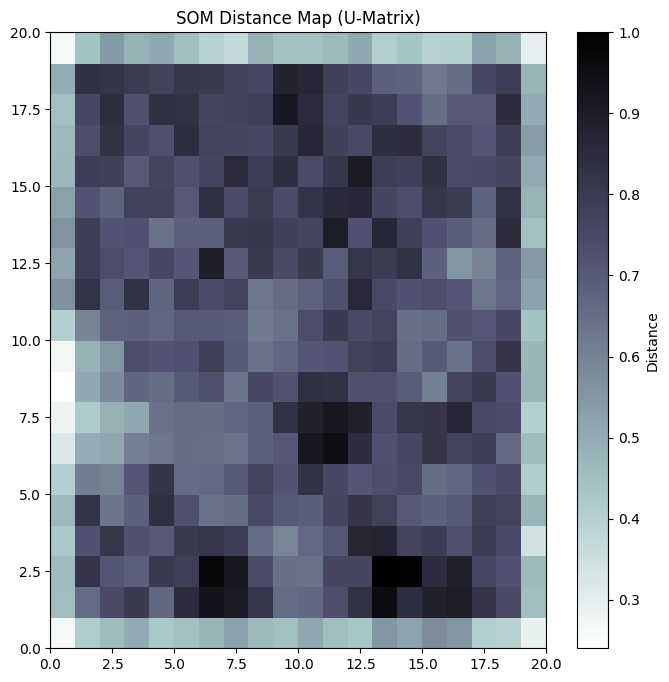

In [68]:
plt.figure(figsize=(8,8))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar(label='Distance')
plt.title('SOM Distance Map (U-Matrix)')
plt.show()

The U-Matrix (Unified Distance Matrix) visualizes the average distance between neighboring neurons in the Self-Organizing Map.
Darker regions represent neurons that are close in feature space (i.e., similar digit patterns), while lighter regions mark larger distances, indicating boundaries between clusters.
Thus, the lighter zones outline transitions between different digit groups, revealing how the SOM organizes high-dimensional MNIST data into distinct topological clusters.

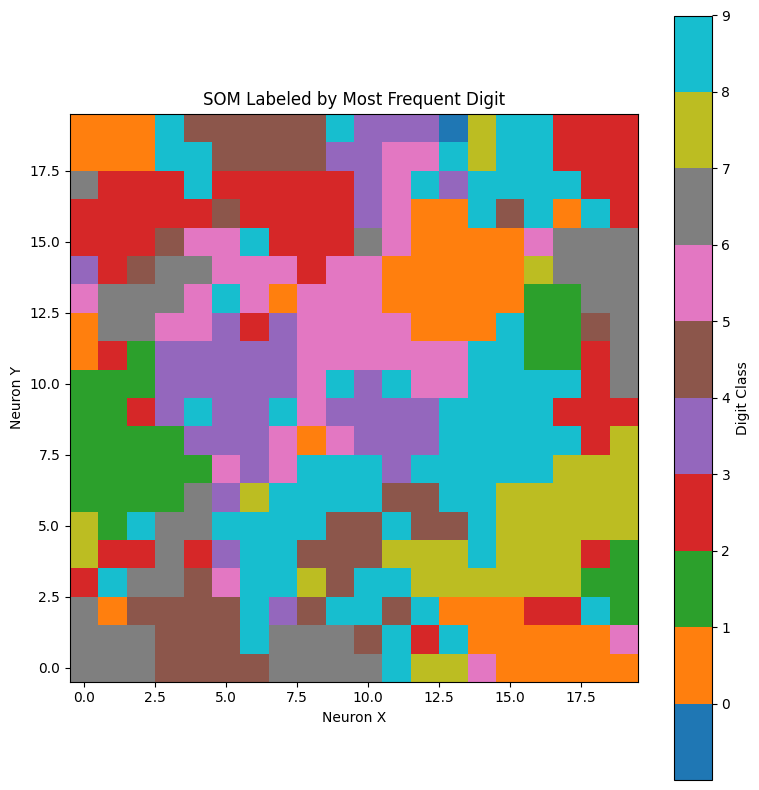

In [69]:
som_x, som_y = 20, 20  # same as before
win_map = som.win_map(X_subset)

label_grid = np.full((som_x, som_y), -1, dtype=int)
for i in range(som_x):
    for j in range(som_y):
        samples = win_map.get((i, j), [])
        if len(samples) > 0:
            # find corresponding labels
            label_indices = [np.where((X_subset == s).all(axis=1))[0][0] for s in samples]
            mapped_labels = y_subset[label_indices]
            label_grid[i, j] = np.bincount(mapped_labels).argmax()

# --- Plot labeled map ---
plt.figure(figsize=(8,8))
plt.imshow(label_grid.T, cmap="tab10", origin="lower")
plt.title("SOM Labeled by Most Frequent Digit")
plt.xlabel("Neuron X")
plt.ylabel("Neuron Y")
cbar = plt.colorbar(ticks=range(10))
cbar.set_label("Digit Class")
plt.tight_layout()
plt.show()

This map abovee shows each neuron in the Self-Organizing Map (SOM) labeled by the most frequent digit class it represents.
Each color corresponds to a different digit, providing a clear overview of how the SOM organizes handwritten digits in the 2D grid.
Large, contiguous color regions indicate well-formed clusters of similar digits, while boundaries or mixed colors highlight areas of overlap between visually similar digits (e.g., 4 and 9, or 3 and 8).
This visualization effectively summarizes the SOM’s learned structure, showing which parts of the map correspond to which digit groups.